In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tabulate import tabulate

In [30]:
df = pd.read_csv("../data/compas-scores-two-years.csv")
df = df[df["days_b_screening_arrest"] <= 30]
df = df[df["days_b_screening_arrest"] >= -30]
df.drop([
    "id",
    "name",
    "first",
    "last",
    "dob",
    "violent_recid",
    "decile_score.1"
], axis=1, inplace=True)

df["binary_approximation"] = df["score_text"].apply(lambda x: 0 if x == "Low" else 1)
df["score_without_medium"] = df["score_text"].apply(lambda x: 0 if x == "Low" else (None if x == "Medium" else 1))

In [31]:
def histogram(kolonne, gruppe):
    temp_df = df.where(df[kolonne] == gruppe)
    temp_df.dropna(subset=kolonne, inplace=True)

    fig, ax = plt.subplots(1, 2)

    h = np.histogram(temp_df["decile_score"], bins=np.arange(0.5, 11, 1))[0]
    h = np.asarray(h, dtype=float)
    h /= h.sum()
    ax[0].bar(np.arange(1, 11, 1), h)

    keys = ["Low", "Medium", "High"]
    counts = temp_df["score_text"].value_counts()[keys].to_numpy(dtype=float)
    counts /= counts.sum()
    ax[1].bar(keys, counts)

    ax[0].set_xlabel("Desil score")
    ax[1].set_xlabel("Score tekst")
    ax[0].set_ylabel("Andel av gruppen")
    ax[1].set_ylabel("Andel av gruppen")

    fig.set_size_inches(10,5)
    fig.suptitle("Det som ble predikert av algoritmen for " + kolonne + ": " + gruppe)

    plt.tight_layout()

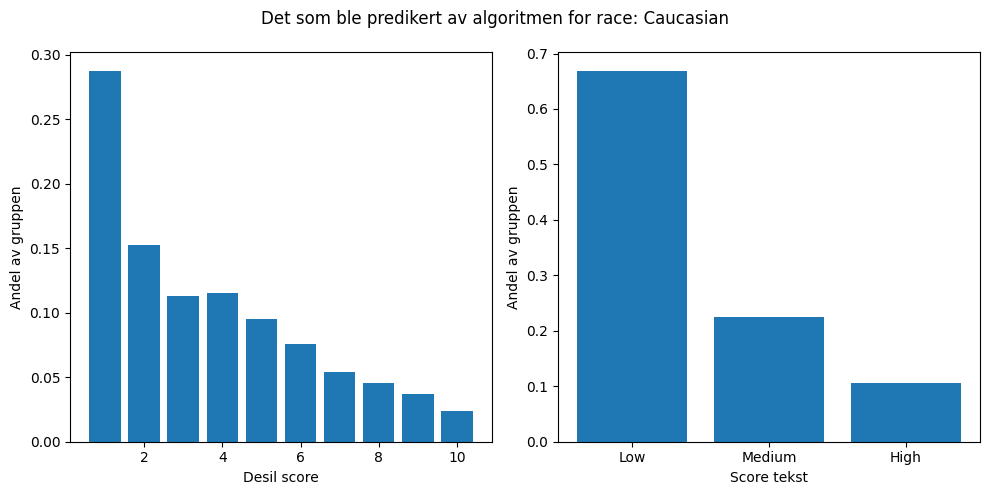

In [32]:
histogram("race", "Caucasian")

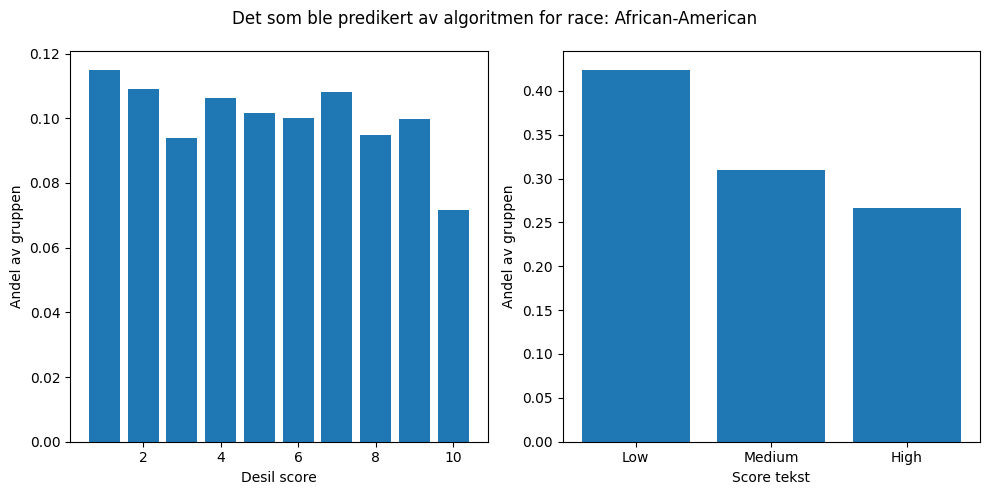

In [33]:
histogram("race", "African-American")

In [34]:
def drop_all_except(dataframe, to_keep, inplace=True):
    """fjerner alle kolonnene fra dataframe bortsett fra de i listen/arrayet to_keep"""
    # liste med alle kolonnene
    to_drop = list(df.columns.to_numpy())

    for keep in to_keep:
        to_drop.remove(keep)
    
    return dataframe.drop(to_drop, inplace=inplace, axis=1)

In [56]:
def truth_table(kolonne, gruppe, pred="binary_approximation"):
    # lager en dataframe med kun de relevante kolonnene
    copy_df = df.copy()
    drop_all_except(copy_df, ["sex", "race", pred, "is_recid"])
    copy_df.dropna(subset=pred, inplace=True)

    # henter ut den ønskede gruppen
    if kolonne is not None and gruppe is not None:
        copy_df = copy_df.where(df[kolonne] == gruppe)
        copy_df.dropna(subset=kolonne, inplace=True)


    actual = copy_df["is_recid"].to_numpy()
    prediction = copy_df[pred].to_numpy()

    true_positives = np.logical_and(actual, prediction).mean()
    false_positives = np.logical_and(actual == 0, prediction).mean()
    true_negatives = np.logical_and(actual == 0, prediction == 0).mean()
    false_negatives = np.logical_and(actual, prediction == 0).mean()

    # lager og printer tabell
    table = list()

    if kolonne is not None and gruppe is not None:
        table.append([f"{kolonne}: {gruppe}", "Actual true", "actual false", "sum"])
    else:
        table.append(["All", "Actual true", "actual false", "sum"])

    table.append(["Predicted true", true_positives, false_positives, true_positives + false_positives])
    table.append(["Predicted false", false_negatives, true_negatives, false_negatives + true_negatives])
    table.append(["sum", true_positives+false_negatives, false_positives + true_negatives])
    print(tabulate(table, tablefmt="mixed_grid"))
    print("Positiv prediktiv verdi: ", true_positives/(true_positives+false_positives))

In [57]:
truth_table(None, None)

┍━━━━━━━━━━━━━━━━━┯━━━━━━━━━━━━━━━━━━━━━┯━━━━━━━━━━━━━━━━━━━━━┯━━━━━━━━━━━━━━━━━━━━┑
│ All             │ Actual true         │ actual false        │ sum                │
├─────────────────┼─────────────────────┼─────────────────────┼────────────────────┤
│ Predicted true  │ 0.29439403758911215 │ 0.15132858068697344 │ 0.4457226182760856 │
├─────────────────┼─────────────────────┼─────────────────────┼────────────────────┤
│ Predicted false │ 0.19005184705119896 │ 0.3642255346727155  │ 0.5542773817239145 │
├─────────────────┼─────────────────────┼─────────────────────┼────────────────────┤
│ sum             │ 0.48444588464031113 │ 0.515554115359689   │                    │
┕━━━━━━━━━━━━━━━━━┷━━━━━━━━━━━━━━━━━━━━━┷━━━━━━━━━━━━━━━━━━━━━┷━━━━━━━━━━━━━━━━━━━━┙
Positiv prediktiv verdi:  0.6604870956015993


In [51]:
truth_table("race", "African-American")

┍━━━━━━━━━━━━━━━━━━━━━━━━┯━━━━━━━━━━━━━━━━━━━━━┯━━━━━━━━━━━━━━━━━━━━━┯━━━━━━━━━━━━━━━━━━━━┑
│ race: African-American │ Actual true         │ actual false        │ sum                │
├────────────────────────┼─────────────────────┼─────────────────────┼────────────────────┤
│ Predicted true         │ 0.39307086614173226 │ 0.18299212598425196 │ 0.5760629921259842 │
├────────────────────────┼─────────────────────┼─────────────────────┼────────────────────┤
│ Predicted false        │ 0.16535433070866143 │ 0.2585826771653543  │ 0.4239370078740158 │
├────────────────────────┼─────────────────────┼─────────────────────┼────────────────────┤
│ sum                    │ 0.5584251968503937  │ 0.4415748031496063  │                    │
┕━━━━━━━━━━━━━━━━━━━━━━━━┷━━━━━━━━━━━━━━━━━━━━━┷━━━━━━━━━━━━━━━━━━━━━┷━━━━━━━━━━━━━━━━━━━━┙
Positiv prediktiv verdi:  0.6823400765445599


In [52]:
truth_table("race", "Caucasian")

┍━━━━━━━━━━━━━━━━━┯━━━━━━━━━━━━━━━━━━━━━┯━━━━━━━━━━━━━━━━━━━━━┯━━━━━━━━━━━━━━━━━━━━┑
│ race: Caucasian │ Actual true         │ actual false        │ sum                │
├─────────────────┼─────────────────────┼─────────────────────┼────────────────────┤
│ Predicted true  │ 0.20446980504041845 │ 0.12648597242035187 │ 0.3309557774607703 │
├─────────────────┼─────────────────────┼─────────────────────┼────────────────────┤
│ Predicted false │ 0.21112696148359486 │ 0.4579172610556348  │ 0.6690442225392297 │
├─────────────────┼─────────────────────┼─────────────────────┼────────────────────┤
│ sum             │ 0.41559676652401334 │ 0.5844032334759867  │                    │
┕━━━━━━━━━━━━━━━━━┷━━━━━━━━━━━━━━━━━━━━━┷━━━━━━━━━━━━━━━━━━━━━┷━━━━━━━━━━━━━━━━━━━━┙
Positiv prediktiv verdi:  0.617816091954023


In [55]:
tab = list()

for s in df["score_text"].unique():
    line = [s]
    temp_df = df.where(df["score_text"] == s)
    for r in ["African-American", "Caucasian"]:
        temp_temp_df = temp_df.where(temp_df["race"] == r)
        temp_temp_df.dropna(subset="is_recid", inplace=True)
        recid_rate = temp_temp_df["is_recid"].to_numpy().mean()
        line.append(recid_rate)
    tab.append(line)

for s in sorted(df["decile_score"].unique()):
    line = [s]
    temp_df = df.where(df["decile_score"] == s)
    for r in ["African-American", "Caucasian"]:
        temp_temp_df = temp_df.where(temp_df["race"] == r)
        temp_temp_df.dropna(subset="is_recid", inplace=True)
        recid_rate = temp_temp_df["is_recid"].to_numpy().mean()
        line.append(recid_rate)
    tab.append(line)

print("Recidivism rates for the predicted scores and the race")
print(tabulate(tab, headers=["Score", "African-American", "Caucasian"], tablefmt="mixed_grid"))

Recidivism rates for the predicted scores and the race
┍━━━━━━━━━┯━━━━━━━━━━━━━━━━━━━━┯━━━━━━━━━━━━━┑
│ Score   │   African-American │   Caucasian │
┝━━━━━━━━━┿━━━━━━━━━━━━━━━━━━━━┿━━━━━━━━━━━━━┥
│ Low     │           0.390045 │    0.315565 │
├─────────┼────────────────────┼─────────────┤
│ Medium  │           0.602642 │    0.556025 │
├─────────┼────────────────────┼─────────────┤
│ High    │           0.775148 │    0.748879 │
├─────────┼────────────────────┼─────────────┤
│ 1       │           0.254795 │    0.229752 │
├─────────┼────────────────────┼─────────────┤
│ 2       │           0.349711 │    0.342679 │
├─────────┼────────────────────┼─────────────┤
│ 3       │           0.469799 │    0.369748 │
├─────────┼────────────────────┼─────────────┤
│ 4       │           0.507418 │    0.440329 │
├─────────┼────────────────────┼─────────────┤
│ 5       │           0.529412 │    0.47     │
├─────────┼────────────────────┼─────────────┤
│ 6       │           0.628931 │    0.6      │
├────

Kan se av tabellen at for alle de mulige scorene (bortsett fra 8, der det er relativt jevnt), er det flere av de svarte som får scoren som faktisk gjør en forbrytelse til innen to år. 